# Step 6: Filter out incoherent matches

In [1]:
import os
from functools import partial
import numpy as np
from phathom import plotting
from phathom.registration import registration as reg
from phathom.registration.pcloud import estimate_affine, register_pts
from phathom.utils import pickle_save

In [2]:
working_dir = '/home/jswaney/coregistration'
voxel_size = (2.0, 1.6, 1.6)  # z, y, x

In [3]:
# Load blobs
fixed_pts_path = 'fixed/blobs.npy'
moving_pts_path = 'moving/blobs.npy'

fixed_pts = np.load(os.path.join(working_dir, fixed_pts_path))
moving_pts = np.load(os.path.join(working_dir, moving_pts_path))
print('keypoints:', fixed_pts.shape, moving_pts.shape)

keypoints: (23637704, 3) (21672500, 3)


In [4]:
# Load matches
idx_fixed_path = 'fixed/match_idx.npy'
idx_moving_path = 'moving/match_idx.npy'

idx_fixed = np.load(os.path.join(working_dir, idx_fixed_path))
idx_moving = np.load(os.path.join(working_dir, idx_moving_path))
print('# matches loaded:', idx_fixed.shape[0])

# matches loaded: 112742


In [5]:
# Extract matching coordinates
fixed_keypts = fixed_pts[idx_fixed]
moving_keypts = moving_pts[idx_moving]

In [6]:
# Convert to um
fixed_keypts_um = fixed_keypts * np.asarray(voxel_size)
moving_keypts_um = moving_keypts * np.asarray(voxel_size)

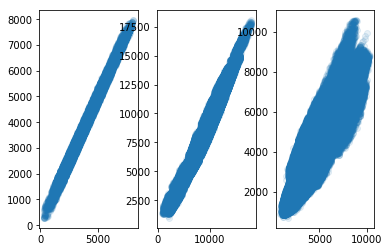

In [7]:
# Show starting coordinate similarity
plotting.plot_correspondence(fixed_keypts_um, moving_keypts_um)

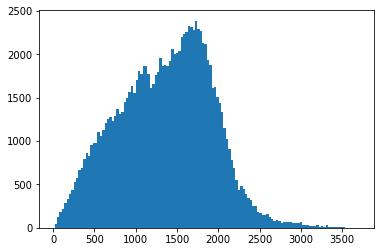

Starting ave. distance [um]: 1360.8574132209717


In [8]:
# Show starting residuals
starting_residuals = reg.match_distance(fixed_keypts_um,
                                        moving_keypts_um)
plotting.plot_hist(starting_residuals, 128)
print('Starting ave. distance [um]:', starting_residuals.mean())

In [9]:
# Use RANSAC to estimate affine transformation
resid_thresh = None
min_samples = 30

ransac, ransac_inliers = estimate_affine(fixed_keypts_um,
                                         moving_keypts_um,
                                         'ransac',
                                         min_samples,
                                         resid_thresh)

In [10]:
# Apply affine transformation
ransac_keypts_um = register_pts(fixed_keypts_um, ransac)

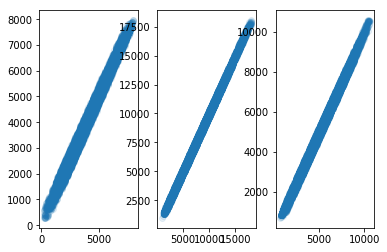

In [11]:
# Show ransac coordinate similarity
plotting.plot_correspondence(ransac_keypts_um, moving_keypts_um)

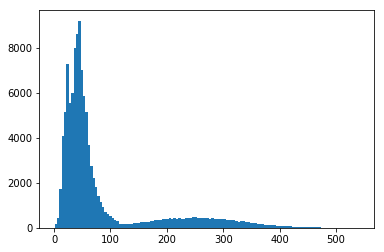

RANSAC ave. distance [um]: 85.30883576915963


In [12]:
# Show residuals after ransac
ransac_residuals = reg.match_distance(ransac_keypts_um,
                                      moving_keypts_um)
plotting.plot_hist(ransac_residuals, 128)
print('RANSAC ave. distance [um]:', ransac_residuals.mean())

In [13]:
# Filter on distance
max_distance = 100

inlier_idx = np.where(ransac_residuals < max_distance)
fixed_keypts_dist = fixed_keypts[inlier_idx]
moving_keypts_dist = moving_keypts[inlier_idx]
fixed_keypts_dist_um = fixed_keypts_um[inlier_idx]
moving_keypts_dist_um = moving_keypts_um[inlier_idx]

In [14]:
# Use sklearn for faster affine transformation, without outliers
degree = 1

model = reg.fit_polynomial_transform(fixed_keypts_dist,
                                     moving_keypts_dist,
                                     degree)
model_z, model_y, model_x = model
affine_transformation = partial(reg.polynomial_transform, 
                                degree=degree,
                                model_z=model_z, 
                                model_y=model_y,
                                model_x=model_x)

In [15]:
# Transform the fixed keypoints in pixel units
affine_keypts = affine_transformation(pts=fixed_keypts)
affine_keypts_dist = affine_keypts[inlier_idx]

In [16]:
# Convert to micron
affine_keypts_um = affine_keypts * np.asarray(voxel_size)
affine_keypts_dist_um = affine_keypts_um[inlier_idx]

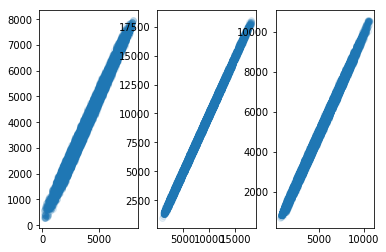

In [17]:
# Show affine coordinate similarity
plotting.plot_correspondence(affine_keypts_um, moving_keypts_um)

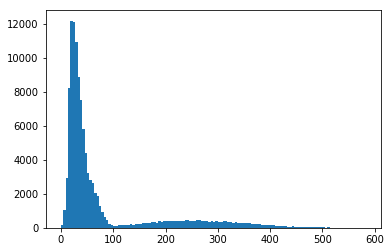

Affine ave. distance [um]: 80.35952299806745


In [18]:
# Show residuals after affine
affine_residuals = reg.match_distance(affine_keypts_um,
                                      moving_keypts_um)
plotting.plot_hist(affine_residuals, 128)
print('Affine ave. distance [um]:', affine_residuals.mean())

In [19]:
# Calculate displacement coherence
n_neighbors = 3

coherences = reg.coherence(n_neighbors, 
                           affine_keypts_dist_um, 
                           moving_keypts_dist_um)
# plotting.plot_hist(coherences, bins=512)
# print('Average coherence: {}'.format(coherences.mean()))

/home/jswaney/anaconda3/envs/phathom/lib/python3.5/site-packages/scipy/spatial/distance.py:698: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [20]:
# Filter out incoherent matches
min_coherence = 0.98

coherent_idx = np.where(coherences > min_coherence)
print('Found {} outliers'.format(len(coherences)-len(coherent_idx[0])))

fixed_keypts_coherent = fixed_keypts_dist[coherent_idx]
affine_keypts_coherent = affine_keypts_dist[coherent_idx]
moving_keypts_coherent = moving_keypts_dist[coherent_idx]

fixed_keypts_coherent_um = fixed_keypts_dist_um[coherent_idx]
affine_keypts_coherent_um = affine_keypts_dist_um[coherent_idx]
moving_keypts_coherent_um = moving_keypts_dist_um[coherent_idx]

Found 5922 outliers


/home/jswaney/anaconda3/envs/phathom/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


In [ ]:
# Plot filtered matches
plotting.plot_pts(affine_keypts_coherent_um,
                  moving_keypts_coherent_um,
                  0.05,
                  affine_keypts_coherent_um,
                  moving_keypts_coherent_um)

In [21]:
# Save the affine transformation
affine_path = 'affine_transformation.pkl'

pickle_save(os.path.join(working_dir, affine_path), 
            affine_transformation)

In [22]:
# Save the filtered match coordinates
fixed_keypts_path = 'fixed_keypts.npy'
affine_keypts_path = 'affine_keypts.npy'
moving_keypts_path = 'moving_keypts.npy'

np.save(os.path.join(working_dir, fixed_keypts_path), 
        fixed_keypts_coherent)
np.save(os.path.join(working_dir, affine_keypts_path), 
        affine_keypts_coherent)
np.save(os.path.join(working_dir, moving_keypts_path), 
        moving_keypts_coherent)